In [4]:
# Import necessary libraries
!pip install keras_preprocessing
import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from keras.models import Model
from warnings import filterwarnings
filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00


In [5]:
train_data = pd.read_csv('/kaggle/input/olid-dataset/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')

train_tweets = train_data[['tweet']] # Extract tweets
train_task_a_labels = train_data[['subtask_a']] # Extract subtask_a labels
train_task_b_labels = train_data[['subtask_b']] # Extract subtask_b labels
train_task_c_labels = train_data[['subtask_c']] # Extract subtask_c labels

train_task_a_labels.columns.values[0] = 'class_a' # Rename class attribute
train_task_b_labels.columns.values[0] = 'class_b' # Rename class attribute
train_task_c_labels.columns.values[0] = 'class_c' # Rename class attribute

In [6]:
def clean_tweets(df):
    tweet_colm = df.iloc[:,0]
    for i in range(len(tweet_colm)):
        data = tweet_colm[i]
        x = [word for word in data.split() if word.lower() not in stopwords]
        data_1 = " ".join(x)
        data_1 = [data_1]
        tweet_colm[i] = data_1[0]
    df.loc[:, 'tweet'] = tweet_colm
    
    punctuations = string.punctuation
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '')
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '')
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and')
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','')
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','')
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','')
    df.loc[:, 'tweet'] = df.tweet.str.lower()

    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')

    df.loc[:, 'tweet'] = df.astype(str).apply(
        lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')
    )
    df.loc[:, 'tweet'] = df.tweet.str.strip()

clean_tweets(train_tweets)

In [7]:
train_task_a_data = train_tweets.join(train_task_a_labels)

train_task_b_data = train_tweets.join(train_task_b_labels)
train_task_b_data = train_task_b_data.dropna() 

train_task_c_data = train_tweets.join(train_task_c_labels)
train_task_c_data = train_task_c_data.dropna()

In [8]:
# Read tweets from test sets
test_tweet_a = pd.read_csv('/kaggle/input/olid-dataset/testset-levela.tsv', delimiter='\t', encoding='utf-8')
test_tweet_b = pd.read_csv('/kaggle/input/olid-dataset/testset-levelb.tsv', delimiter='\t', encoding='utf-8')
test_tweet_c = pd.read_csv('/kaggle/input/olid-dataset/testset-levelc.tsv', delimiter='\t', encoding='utf-8')

In [9]:
# Read tweet labels
test_label_a = pd.read_csv('/kaggle/input/olid-dataset/labels-levela.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_a'])
test_label_b = pd.read_csv('/kaggle/input/olid-dataset/labels-levelb.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_b'])
test_label_c = pd.read_csv('/kaggle/input/olid-dataset/labels-levelc.csv', encoding='utf-8', 
                         index_col=False, names=['id', 'class_c'])

In [10]:
# Merge tweets with labels by id
test_tweet_a = test_tweet_a.merge(test_label_a, on='id')
test_tweet_b = test_tweet_b.merge(test_label_b, on='id')
test_tweet_c = test_tweet_c.merge(test_label_c, on='id')

In [11]:
# Drop id column
test_tweet_a = test_tweet_a.drop(columns='id')
test_tweet_b = test_tweet_b.drop(columns='id')
test_tweet_c = test_tweet_c.drop(columns='id')

In [12]:
# Clean tweets in test sets
clean_tweets(test_tweet_a)
clean_tweets(test_tweet_b)
clean_tweets(test_tweet_c)

In [13]:
# Apply quotes to cleaned tweets
test_tweet_a.update(test_tweet_a[['tweet']].applymap('\'{}\''.format))
test_tweet_b.update(test_tweet_b[['tweet']].applymap('\'{}\''.format))
test_tweet_c.update(test_tweet_c[['tweet']].applymap('\'{}\''.format))

In [14]:
X_train = train_task_a_data.tweet
Y_train = train_task_a_data.class_a

X_test = test_tweet_a.tweet
Y_test = test_tweet_a.class_a

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_train = Y_train.reshape(-1, 1)

Y_test = le.transform(Y_test)
Y_test = Y_test.reshape(-1, 1)

In [15]:
max_words = 20623
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)

In [16]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [17]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           1031150   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [18]:
model.fit(sequences_matrix, Y_train, batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
83/83 [==============================] - 6s 23ms/step - loss: 0.6186 - accuracy: 0.6723 - val_loss: 0.5594 - val_accuracy: 0.7096
Epoch 2/10
83/83 [==============================] - 1s 13ms/step - loss: 0.4480 - accuracy: 0.7998 - val_loss: 0.5189 - val_accuracy: 0.7621
Epoch 3/10
83/83 [==============================] - 1s 12ms/step - loss: 0.4092 - accuracy: 0.8575 - val_loss: 0.5715 - val_accuracy: 0.7549


In [19]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

y_pred = model.predict(test_sequences_matrix)
y_pred = (y_pred > 0.8)

print(classification_report(Y_test, y_pred))

27/27 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       620
           1       0.81      0.27      0.40       240

    accuracy                           0.78       860
   macro avg       0.79      0.62      0.63       860
weighted avg       0.78      0.78      0.73       860



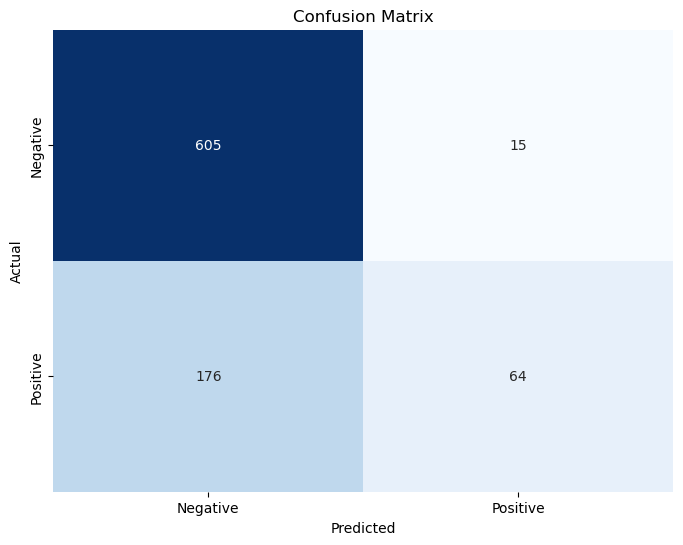

In [20]:
conf_mat = confusion_matrix(Y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Extract LSTM layer embeddings
lstm_layer_model = Model(inputs=model.input, outputs=model.layers[-3].output)
lstm_embeddings = lstm_layer_model.predict(test_sequences_matrix)

27/27 [==============================] - 0s 4ms/step


In [22]:
# Perform t-SNE on LSTM embeddings
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(lstm_embeddings)

In [24]:
# Create a DataFrame for t-SNE embeddings
tsne_df = pd.DataFrame(data=tsne_embeddings, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Label'] = Y_test

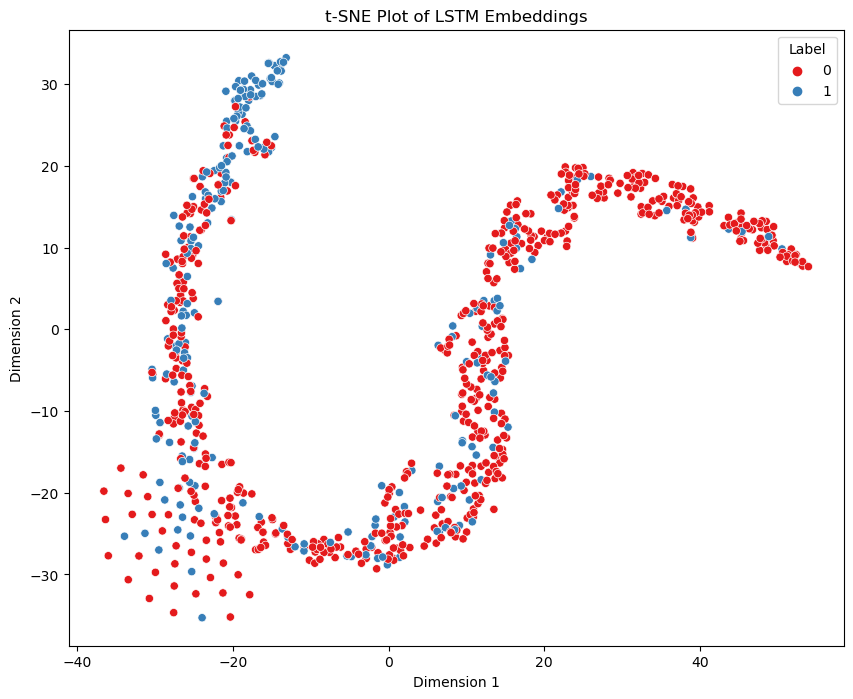

In [25]:
# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='Label', palette='Set1')
plt.title('t-SNE Plot of LSTM Embeddings')
plt.show()

In [26]:
# Obtain the intermediate layer output
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('FC1').output)
intermediate_output = intermediate_layer_model.predict(sequences_matrix)

414/414 [==============================] - 2s 5ms/step


In [27]:
# Apply t-SNE to the intermediate output
tsne = TSNE(n_components=2, random_state=42)
tsne_output = tsne.fit_transform(intermediate_output)

In [28]:
# Create a DataFrame for t-SNE embeddings
tsne_df = pd.DataFrame(data=tsne_output, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Label'] = Y_train

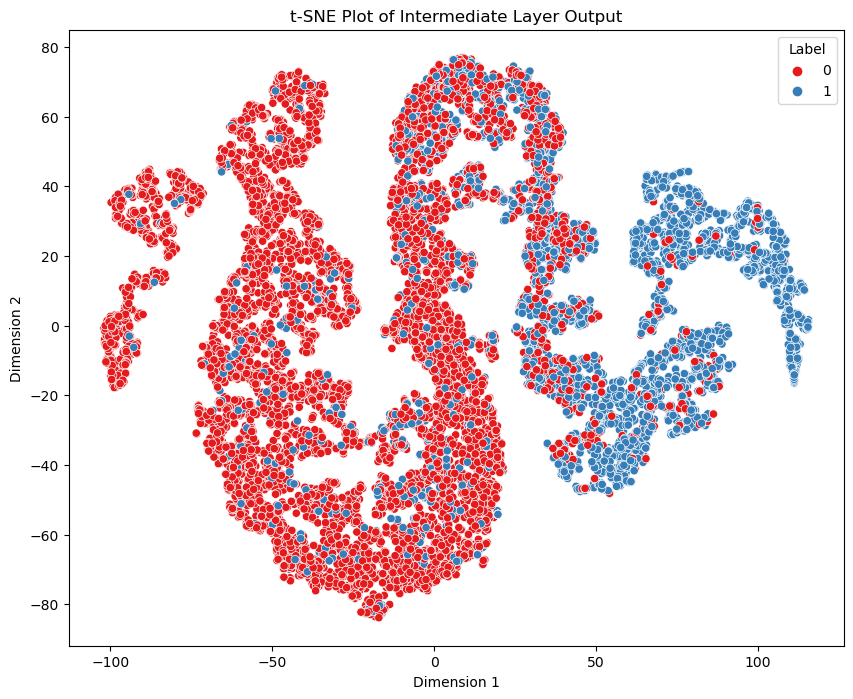

In [29]:
# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='Label', palette='Set1')
plt.title('t-SNE Plot of Intermediate Layer Output')
plt.show()